In [1]:
!nvidia-smi

Sat Jul 25 12:38:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install bert-for-tf2 >> /dev/null

In [3]:
!pip install tqdm >> /dev/null

In [4]:
!pip install --upgrade grpcio >> /dev/null

In [5]:
!pip install tensorflow-gpu >> /dev/null

In [6]:
!pip install sentencepiece >> /dev/null

In [7]:
import os
import math
import datetime

import pandas as pd
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
#rc['figure.figsize'] = 12, 8


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
!gdown --id 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output train.csv
!gdown --id 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output valid.csv
!gdown --id 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output test.csv

Downloading...
From: https://drive.google.com/uc?id=1OlcvGWReJMuyYQuOZm149vHWwPtlboR6
To: /content/train.csv
100% 799k/799k [00:00<00:00, 52.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w
To: /content/valid.csv
100% 43.3k/43.3k [00:00<00:00, 15.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF
To: /content/test.csv
100% 43.1k/43.1k [00:00<00:00, 16.5MB/s]


In [9]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
valid = pd.read_csv("valid.csv")

In [10]:
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


In [11]:
test.head()

,text,intent
0,add sabrina salerno to the grime instrumentals...,AddToPlaylist
1,i want to bring four people to a place that s ...,BookRestaurant
2,put lindsey cardinale into my hillary clinton ...,AddToPlaylist
3,will it snow in mt on june 13 2038,GetWeather
4,play signe anderson chant music that is newest,PlayMusic


In [12]:
valid.head()

,text,intent
0,i d like to have this track onto my classical ...,AddToPlaylist
1,add the album to my flow español playlist,AddToPlaylist
2,add digging now to my young at heart playlist,AddToPlaylist
3,add this song by too poetic to my piano ballad...,AddToPlaylist
4,add this album to old school death metal,AddToPlaylist


In [13]:
# extend the training data by appending the valid
train = train.append(valid).reset_index(drop=True)
# train = train.drop(['index'],axis=1)

In [14]:
train.tail()

,text,intent
13779,is any cinema playing the spirit of youth,SearchScreeningEvent
13780,what are the movie times for animated movies i...,SearchScreeningEvent
13781,what s the movie schedule at great escape thea...,SearchScreeningEvent
13782,show the times for cheers for miss bishop at d...,SearchScreeningEvent
13783,i want to see married to the enemy 2 at a cinema,SearchScreeningEvent


In [15]:
train.shape

(13784, 2)

Text(0.5, 1.0, 'number of count per intent')

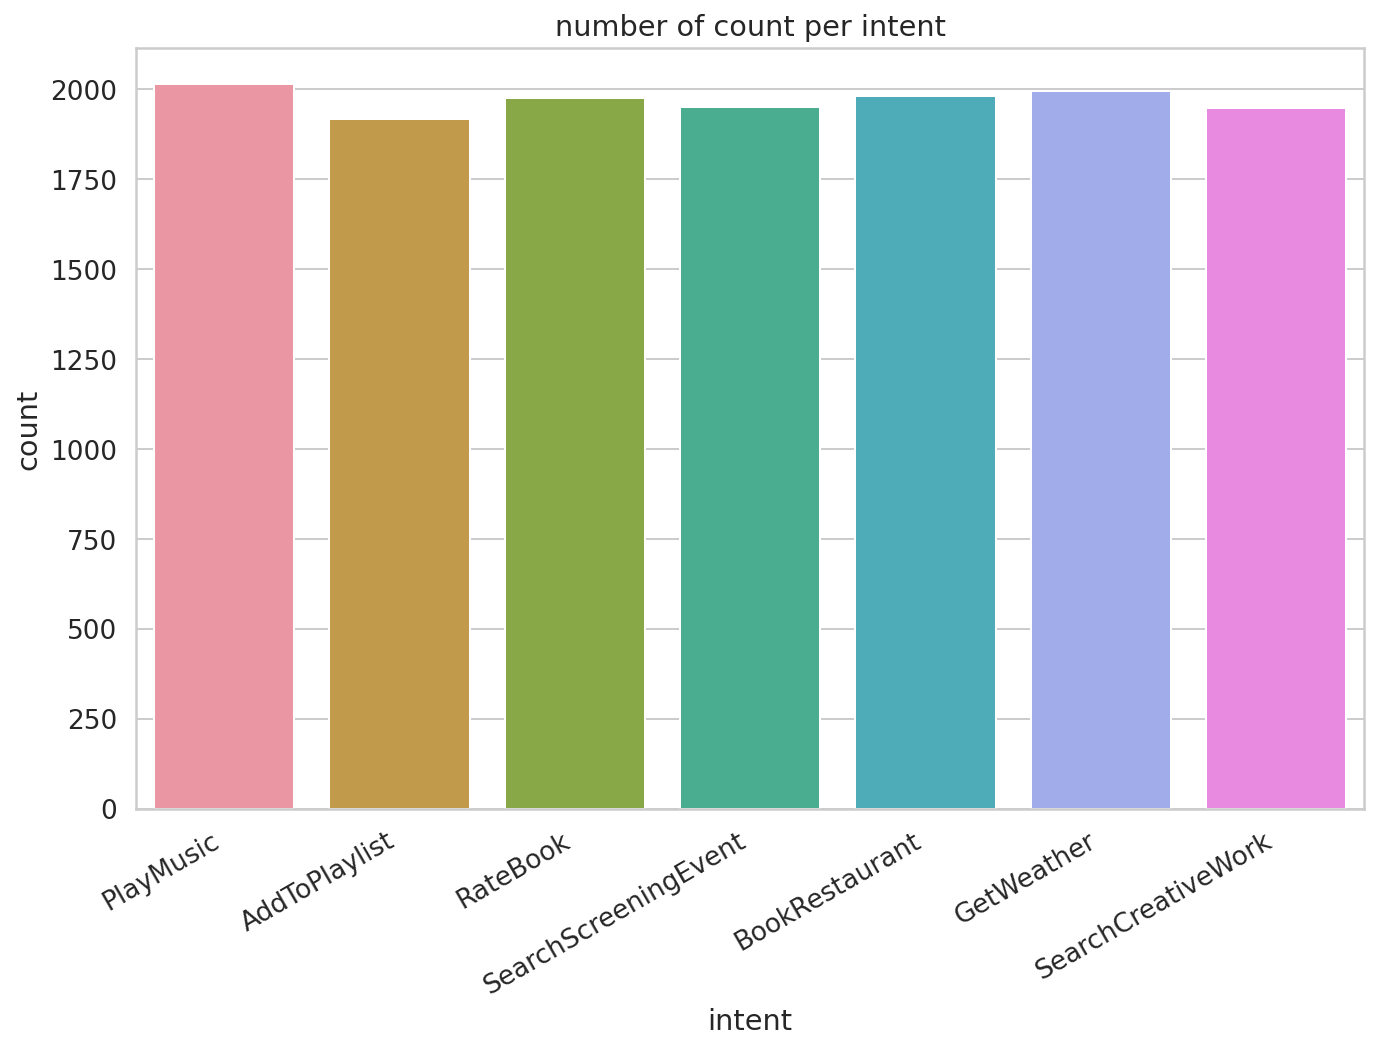

In [16]:

#train['intent'].value_counts().plot(kind='barh')

fig_dims = (11, 7)
fig, ax = plt.subplots(figsize=fig_dims)
chart = sns.countplot(train.intent, ax=ax)
chart.set_xticklabels(chart.get_xticklabels(), rotation = 30, horizontalalignment='right');
plt.title("number of count per intent")

intent recognition using bert

In [17]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-07-25 12:40:30--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 66.102.1.128, 172.253.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   127MB/s    in 3.1s    

2020-07-25 12:40:33 (127 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [34]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [19]:
os.makedirs("model",exist_ok=True)

In [20]:
!mv uncased_L-12_H-768_A-12/ model

In [21]:
# files
bert_model_name = "uncased_L-12_H-768_A-12"
bert_ckpt_dir  = os.path.join("model/", bert_model_name)
bert_ckpt_file  = os.path.join(bert_model_name, "bert_model.ckpt")
bert_config_file = os.path.join(bert_model_name,"bert_config.json")

In [31]:
bert_ckpt_dir

'model/uncased_L-12_H-768_A-12'

In [32]:
bert_ckpt_file

'uncased_L-12_H-768_A-12/bert_model.ckpt'

In [23]:
class IntentDetectionData:
  DATA_COLUMN = 'text'
  LABEL_COLUMN = 'intent'

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192): # classes means intents(playmusic,addweather)
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes

    train, test = map(lambda df: df.reindex(df[IntentDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])

    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    self.max_seq_len = min(self.max_seq_len, max_seq_len) # it takes minum between max_seq_len or existing text length whichever is minimum
    # padding
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []

    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      # two special tokens 1st is cls:- sequence is started
      # 2nd is sep:- seperate
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]

      # convert tokenize words into integer
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)

      # max seq len
      self.max_seq_len = max(self.max_seq_len, len(token_ids))

      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []

    for input_ids in ids:
      # cut_point = min(len(input_ids), self.max_seq_len - 2) # self.max_seq_len - 2) cut 2 because we took two CEP and SEP
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids)) # we put 0 if we have 25 max length and our input is 21 so qw add four 0 to the input
      x.append(np.array(input_ids))

    return np.array(x)

Preprocessing

In [24]:
# create tokenizer
tokenizer = FullTokenizer(os.path.join(bert_ckpt_dir, 'vocab.txt' ))

In [25]:
tokenizer.tokenize("i can't wait to play football")

['i', 'can', "'", 't', 'wait', 'to', 'play', 'football']

In [26]:
tokens = tokenizer.tokenize("i can't wait to play football")
tokenizer.convert_tokens_to_ids(tokens)

[1045, 2064, 1005, 1056, 3524, 2000, 2377, 2374]

Create model

In [27]:
def create_model(max_seq_len,bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
    bc = StockBertConfig.from_json_string(reader.read()) # read the bert config file
    bert_params = map_stock_config_to_params(bc)
    bert_params.adapter_size = None # adapter_size helps us to fine tune faster we declare NOne because we have less data
    bert = BertModelLayer.from_params(bert_params, name="bert")
    
  input_ids = keras.layers.Input(shape=max_seq_len, dtype='int32', name='input_ids')
  bert_output = bert(input_ids)

  print('Bert shape:', bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:,0,:])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  # flattern 
  logits = keras.layers.Dense(units=786,activation='tanh')(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape = (None, max_seq_len))

  load_stock_weights(bert,bert_ckpt_file)

  return model


In [28]:
classes = train.intent.unique().tolist()

data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

13784it [00:05, 2451.64it/s]
700it [00:00, 2513.48it/s]


In [35]:
model = create_model(data.max_seq_len,bert_ckpt_file)

Bert shape: (None, 38, 768)
Done loading 196 BERT weights from: uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fc4503dc9e8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [36]:
data.train_x.shape

(13784, 38)

In [37]:
train.text[0]

'listen to westbam alumb allergic on google music'

In [38]:
data.train_x[0]

array([ 101, 2377, 3769,  102,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0])

In [39]:
data.train_y[0]

0

In [40]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 38)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 38, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 786)               604434    
_________________________________________________________________
dropout_1 (Dropout)          (None, 786)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 5509  

In [41]:
model.compile(
    optimizer = keras.optimizers.Adam(1e-5),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = [keras.metrics.SparseCategoricalCrossentropy(name="accuracy")]
)

In [50]:
log_dir = 'log/intent_detection' + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
    x = data.train_x,
    y = data.train_y,
    validation_split = 0.1, # in paper
    batch_size = 16, # in paper
    shuffle = True,
    epochs = 5, # in paper
    callbacks = [tensorboard_callback]
)


Epoch 1/5
776/776 [==============================] - 483s 622ms/step - loss: 1.3099 - accuracy: 0.4249 - val_loss: 1.1703 - val_accuracy: 0.0269
Epoch 2/5
776/776 [==============================] - 478s 616ms/step - loss: 1.1834 - accuracy: 0.0957 - val_loss: 1.1686 - val_accuracy: 0.0280
Epoch 3/5
776/776 [==============================] - 477s 615ms/step - loss: 1.1788 - accuracy: 0.0882 - val_loss: 1.1706 - val_accuracy: 0.0467
Epoch 4/5
776/776 [==============================] - 477s 614ms/step - loss: 1.1772 - accuracy: 0.0832 - val_loss: 1.1698 - val_accuracy: 0.0479
Epoch 5/5
776/776 [==============================] - 476s 613ms/step - loss: 1.1761 - accuracy: 0.0852 - val_loss: 1.1686 - val_accuracy: 0.0323


In [51]:
_ ,test_acc = model.evaluate(data.test_x, data.test_y)
test_acc

22/22 [==============================] - 5s 233ms/step - loss: 1.1909 - accuracy: 0.3318


0.33183538913726807

In [53]:
data.train_x.shape

(13784, 38)

In [54]:
data.test_x.shape

(700, 38)

In [55]:
data.train_y.shape

(13784,)

In [56]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [60]:
print(classification_report(data.test_y,y_pred,target_names = classes))

                      precision    recall  f1-score   support

           PlayMusic       0.99      0.98      0.98        86
       AddToPlaylist       0.99      1.00      1.00       124
            RateBook       1.00      1.00      1.00        80
SearchScreeningEvent       1.00      0.88      0.94       107
      BookRestaurant       0.99      1.00      0.99        92
          GetWeather       1.00      0.99      1.00       104
  SearchCreativeWork       0.88      0.99      0.93       107

            accuracy                           0.98       700
           macro avg       0.98      0.98      0.98       700
        weighted avg       0.98      0.98      0.98       700



In [66]:
sentencss=[
           'play song now',
           'rate this book good',
           'today is hot day'
]

tokens = map(tokenizer.tokenize, sentencss)
tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], tokens)
token_ids = list(map(tokenizer.convert_tokens_to_ids, tokens))

token_ids = map(lambda tids: tids + [0] * (data.max_seq_len -len(tids)),token_ids)
token_ids = np.array(list(token_ids))
prediction = model.predict(token_ids).argmax(axis=-1)

for text, label in zip(sentencss,prediction):
  print("test:", text)
  print("Intents:", classes[label])
  print()

test: play song now
Intents: PlayMusic

test: rate this book good
Intents: RateBook

test: today is hot day
Intents: GetWeather

